#### <u>Was ist das hier?</u>
Das hier ist ein Jupyter-Notebook, das ich in JupyterLab erstellt habe. Es ist ein interaktives Dokument, das es ermöglicht, Code zu schreiben und auszuführen, Daten zu visualisieren und schriftlich die Arbeitsschritte in einer einzigen Umgebung festzuhalten. Dieser Text, den du/Sie gerade liest/lesen, befindet sich in einer „Zelle.“ Das Inhaltsverzeichnis weiter unten befindet sich in einer separaten Zelle. Zellen können unabhängig voneinander ausgeführt werden; Notebooks sind nicht einfach lange Programme, die insgesamt ausgeführt werden müssten.  
Der Vorteil für die Datenanalyse liegt darin, dass Plots, Visualisierungen und Code von erklärenden Texten in natürlicher Sprache begleitet werden können. Links erscheinen in [Blau](#toc) und führen zu anderen Teilen des Dokuments. Jeglicher Code in diesem Notebook ist Python-Code. 

#### <u>Worum geht es hier?</u>
Dieses Notebook enthält eine kleine Beispielanalyse der Wahlergebnisse im Lande Bremen der Bundestagswahl 2021 auf Stadtteilebene. Es geht mir v. a. darum, eine breite Palette an Wissen zu demonstrieren; die tatsächlichen Ergebnisse der Analyse sind nachrangig.  
Erst bereite ich einige Daten vom Bremer Landesamt für Statistik auf. Dies umfasst die tatsächlichen Wahlergebnisse aber auch einige soziale Daten, von denen ich vermutete, dass sie einen Einfluss haben könnten – z. B. die Arbeitslosenquote oder der Anteil der Bevölkerung, der im (bremenweit errechneten) untersten Einkommensfünftel lebt.  
Die anschließende Analyse erkläre ich weiter unten. Aber einige Einsichten, die man aus den Daten herausbekommt, sind die folgenden:  
1. Die Stadtteile, die tendenziell die SPD wählen, zeigen ein [ähnliches soziales Profil](#2,2,e) wie die, die eher die AfD wählen. (Genau) ein latenter Faktor, der als „Sozialschwäche“ bezeichnet werden könnte, erklärt etwa die Hälfte der Unterschiede in den Stimmenanteilen zwischen SPD und AfD.
2. Die Zusammenhänge zwischen den sozialen Variablen und Wahlergebnissen sind [linear und simpel](#2,4). Es gibt keine erheblichen Nichtlinearitäten oder Interaktionen zwischen verschiedenen Variablen.
3. Der Erststimmenanteil der SPD korreliert zwar erheblich [negativ mit der Wahlbeteiligung](#Wahlbeteiligung1), das ist aber [kein echter Effekt](#Wahlbeteiligung2) sondern liegt an starker Multikollinearität mit anderen, wichtigeren Variablen (d. h. die Wahlbeteiligung korreliert stark mit diesen anderen Variablen).
4. SPD-Wähler [splitten ihre Stimmen nicht](#Stimmensplitting). Wer der SPD seine Erststimme gibt, gibt ihr auch die Zweitstimme und umgekehrt.
5. Die [Konkurrenz zwischen den Parteien](#Zweitstimmen-Konkurrenz) um die Zweitstimme ist ausgeprägter als um die Erststimme – mit Ausnahme der Linken.

Unterwegs erkläre ich einige statistische Konzepte wie [P-Werte](#P-Werte) und [Signifikanz](#Signifikanz) oder den [Unterschied](#2,3,d) zwischen Statistiken, die einem erlauben, Dinge zu verstehen, und solche, die gute Voraussagen machen



Unter jedem Titel steht "[Hoch](#toc)." Wenn man da drauf klickt, gelangt man zurück zum Inhaltsverzeichnis.

# Inhaltsverzeichnis<a name="toc"></a>
1. [Daten aufbereiten](#1)
   * [Wahldaten 2021](#1,1)  
   * [Einkommensteuer-Verteilung 2020](#1,2)
   * [Ausländer und Gesamtbevölkerung](#1,3)
   * [Arbeitslose und Hartz IV](#1,4)
   * [Alles Zusammen](#1,5)
2. [Daten analysieren](#2)
   * [Einfache Korrelationen und Plots](#2,1)  
     a) [P-Werte](#P-Werte)  
     b) [Multiple Regression](#2,1,b)  
     c) [Ausreißer?](#2,1,c)  
     d) [Variance Inflation Factor](#2,1,d)  
     e) [ANOVA](#2,1,e)  
   * [Faktorenanalyse](#2,2)  
     a) [Sind die Daten für Faktorenanalyse geeignet?](#2,2,a)  
     b) [Wie viel Faktoren?](#2,2,b)  
     c) [Regression mit Factor Scores](#2,2,c)  
     d) [Signifikanz](#Signifikanz)  
     e) [Auswertung](#2,2,e)  
   * [LASSO und Validierung](#2,3)  
     a) [Das LASSO-Modell anpassen](#2,3,a)  
     b) [Interpretation des LASSO-Modells](#2,3,b)  
     c) [Validieren der Modelle](#2,3,c)  
     d) [Verstehen vs. Voraussagen](#2,3,d)  
   * [Mit Kanonen auf Spatzen: Random Forests und Boosting](#2,4)  
3. [Was könnte man sonst noch machen?](#3)

In [32]:
import pandas as pd
import numpy as np

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import xgboost as xgb

# Daten aufbereiten <a name="1"></a>   
[Hoch](#toc)

*In diesem Teil geht es nur darum, wie die Daten verarbeitet werden mussten, um nutzbar zu sein. Er kann ohne Verständnisverlust übersprungen werden.*

Alle Daten sind vom Landesamt für Statistik, aber sie sind nicht unbedingt im nutzerfreundlichsten Format, weshalb ich alle Daten ein wenig bearbeiten musste und sie nicht einfach direkt ins Notebook laden kann. Mehr zu den einzelnen Verarbeitungen weiter unten, aber zusammengefasst:

1.) Die Wahldaten-Datei enthält Informationen für alle Regionen, auch wenn nur Stadtteildaten gewünscht sind. Einige Zeilen müssen gelöscht werden, da die erste Zeile die Überschrift und nicht die Spaltentitel enthält. Entweder werden einige Zeilen übersprungen oder alle Spalten neu benannt. 

2.) Die Einkommensteuer-Verteilung für Bremen gibt die Grenzen für das unterste und oberste Einkommensfünftel an. Ich berechne für jeden Stadtteil, wie viele Personen unterhalb und oberhalb dieser Grenzen leben, da das statistische Landesamt diese Daten nicht direkt bereitstellt. 

3.) Auch den Anteil an der Gesamtbevölkerung in den Stadtteilen, den Ausländer darstellen, bietet das Landesamt, glaube ich, nicht direkt an. Ich errechne ihn daher selbst.

4.) Die Arbeitslosenquote wird nur vierteljährlich bereitgestellt. Ich berechne daher den Durchschnitt der Quote für das Jahr vor der Bundestagswahl 2021. Dasselbe gilt für die absoluten SGB-II-Leistungen, die nur vierteljährlich vorliegen. Zusätzlich berechne ich die Leistungen pro Kopf, um die Abhängigkeit von der Bevölkerungszahl zu berücksichtigen.

### Wahldaten 2021 <a name="1,1"></a>  
[Hoch](#toc)

Erst- und Zweitstimmen sind auf unterschiedlichen Blättern in der Excel-Datei, können aber fast gleich behandelt werden. Die Zahlen zur Briefwahl sind nur auf dem ersten Blatt und müssen nur davon gelöscht werden. Außerdem ignoriere ich kleine Parteien. Nur SPD, CDU, Grüne, Linke, FDP und AfD bleiben im DataFrame<sup>†</sup>. Die Regionen Seehausen, Strom, Borgfeld und Blockland sind zwischen den Stadtteilen und müssen gesondert entfernt werden.

<br>

<hr style="width: 10%; text-align: left; margin-left: 0;">

<small>† Ein "DataFrame" ist eine mächtigere Version einer Excel-Tabelle. Verschiedene Arten von Daten (Zahlen, Text, Kalenderdaten, ...) können in seinen Zeilen und Spalten gespeichert werden und man kann diese Daten leichter analysieren, filtern oder sonst verarbeiten</small>

In [33]:
erststimmen_2021 = pd.read_excel('Wahldaten 2021.xlsx', sheet_name=0) 

# Fixing the wrongly imported column names.
# Because of the layout, if you don't set that NaN value at [0, 1] to 'region' (or any other not NaN), both the first and the second column get dropped in the next step.
erststimmen_2021.iloc[0,1] = 'region'
erststimmen_2021.columns = erststimmen_2021.iloc[0]

# Dropping Codes, Briefwahl (4 and 5), stärkste Partei (6 and 7), and small parties.
drop_columns = [0, 4, 5, 6, 7] + list(range(20, erststimmen_2021.shape[1]))
erststimmen_2021 = erststimmen_2021.drop(erststimmen_2021.columns[drop_columns], axis=1)

In [34]:
# Isolating the Stadtteile
start_index = erststimmen_2021[erststimmen_2021['region'] == 'Mitte (Bremen)'].index[0]
df_filtered_partial = erststimmen_2021.loc[start_index + 1:]
end_index = df_filtered_partial[df_filtered_partial['region'] == 'Blumenthal'].index[0]

df_filtered = erststimmen_2021.loc[start_index:end_index]

# Dropping rows of non-Stadtteile in between
df_filtered = df_filtered[~df_filtered['region'].isin(['Seehausen', 'Strom', 'Borgfeld', 'Blockland'])]

# Adding in Land Bremen, Stadt Bremen, Stadt Bremerhaven
df_add = erststimmen_2021.iloc[[161, 159, 160]]
erststimmen_2021_sortiert = pd.concat([df_add, df_filtered], ignore_index=True)

# Making the names consistent with my other tables
cleaned_erststimmen_2021 = erststimmen_2021_sortiert
cleaned_erststimmen_2021['region'] = erststimmen_2021_sortiert['region'].replace({'Mitte (Bremen)':'Mitte', 'Oestliche Vorstadt':'Östliche Vorstadt'})


In [35]:
zweitstimmen_2021 = pd.read_excel('Wahldaten 2021.xlsx', sheet_name=1)
zweitstimmen_2021.iloc[0,1] = 'region'
zweitstimmen_2021.columns = zweitstimmen_2021.iloc[0]

# ... Different numbers but same thing
drop_columns = [0, 2, 3] + list(range(16, zweitstimmen_2021.shape[1]))
zweitstimmen_2021 = zweitstimmen_2021.drop(zweitstimmen_2021.columns[drop_columns], axis=1)

# ...
start_index = zweitstimmen_2021[zweitstimmen_2021['region'] == 'Mitte (Bremen)'].index[0]
df_filtered_partial = zweitstimmen_2021.loc[start_index + 1:]
end_index = df_filtered_partial[df_filtered_partial['region'] == 'Blumenthal'].index[0]

df_filtered = zweitstimmen_2021.loc[start_index:end_index]

# ...
df_filtered = df_filtered[~df_filtered['region'].isin(['Seehausen', 'Strom', 'Borgfeld', 'Blockland'])]

# ...
df_add = zweitstimmen_2021.iloc[[161, 159, 160]]
zweitstimmen_2021_sortiert = pd.concat([df_add, df_filtered], ignore_index=True)

# ...
cleaned_zweitstimmen_2021 = zweitstimmen_2021_sortiert
cleaned_zweitstimmen_2021['region'] = zweitstimmen_2021_sortiert['region'].replace({'Mitte (Bremen)':'Mitte', 'Oestliche Vorstadt':'Östliche Vorstadt'})


In [36]:
cleaned_wahl_2021 = pd.merge(cleaned_erststimmen_2021, cleaned_zweitstimmen_2021, on='region')


### Einkommensteuer-Verteilung 2020 <a name="1,2"></a>  
[Hoch](#toc)

Das statistische Landesamt verwendet das veraltete ISO-8859-1-Encoding für seine Symbole, anstelle des neueren UTF-8, das eine größere Anzahl von Symbolen repräsentieren kann und von Pandas – der Bibliothek für DataFrame-Funktionalität – erwartet wird. Zudem kann Pandas nicht korrekt mit Umlauten umgehen, was jedoch kein Fehler des Landesamts ist.

In [37]:
df_einkommen = pd.read_csv('Einkommensteuer-Verteilung 2020.csv', 
                           encoding='ISO-8859-1', 
                           skiprows=2, 
                           on_bad_lines='skip', 
                           sep=';')

# Last rows are just copyright. First column are incomprehensible codes for each region. Third column is the year; 2020 for all of them.
df_einkommen= df_einkommen.drop(df_einkommen.index[242:]).drop(df_einkommen.columns[0], axis=1).drop(df_einkommen.columns[2], axis=1).reset_index(drop=True)

# The column names were a little unwieldy or contained umlauts.
df_einkommen.rename(columns={
    df_einkommen.columns[0]: 'region',
    df_einkommen.columns[1]: 'range_euro',
    df_einkommen.columns[2]: 'num_steuerpflichtige'}, inplace=True)

# More umlauts in the regions
df_einkommen.iloc[:, 0] = df_einkommen.iloc[:, 0].replace({'HÃ¤fen': 'Häfen',
                                                           'Ã\x96stliche': 'Östliche',
                                                           'GrÃ¶pelingen': 'Gröpelingen'}, regex=True)


In [38]:
df_einkommen.head()

,region,range_euro,num_steuerpflichtige
0,Land Bremen,0-5000,51225
1,Land Bremen,5000-10000,24398
2,Land Bremen,10000-15000,27302
3,Land Bremen,15000-20000,29249
4,Land Bremen,20000-25000,27095


Wie diese Daten direkt zeigen, haben im Land Bremen jeweils etwa 20% der Bevölkerung unter 10.000€ und über 50.000€ zu versteuerndes Einkommen. Als nächstes produziere ich daher eine Tabelle, die für jeden Stadtteil den Anteil der Bevölkerung im untersten und obersten Einkommens-Quintil anzeigt (tatsächlich sind es natürlich Einkommen*steuer*-Quintile).

In [39]:
brackets_lo = ['0-5000', '5000-10000']
brackets_hi = ['50000-125000', '125000 oder mehr']

results_arm = []
results_reich = []

counties = df_einkommen['region'].unique()

for county in counties:
    
    county_data = df_einkommen[df_einkommen['region'] == county].copy()
    
    # num_steuerpflichtige is a bunch of strings.
    # The errors='coerce' forces the missing values in "Häfen" to be NaN
    county_data['num_steuerpflichtige'] = pd.to_numeric(county_data['num_steuerpflichtige'], errors='coerce')
    
    lo_bracket_taxpayers = county_data[county_data['range_euro'].isin(brackets_lo)]['num_steuerpflichtige'].sum()
    hi_bracket_taxpayers = county_data[county_data['range_euro'].isin(brackets_hi)]['num_steuerpflichtige'].sum()
    
    # Calculate the proportion
    total_taxpayers = county_data.iloc[-1]['num_steuerpflichtige']
    
    proportion_lo = lo_bracket_taxpayers / total_taxpayers
    proportion_hi = hi_bracket_taxpayers / total_taxpayers
    
    results_arm.append({'region': county, 'anteil_erstes_quint': proportion_lo})
    results_reich.append({'region': county, 'anteil_letztes_quint': proportion_hi})

df_quint_arm = pd.DataFrame(results_arm)
df_quint_reich = pd.DataFrame(results_reich)

df_anteil_einkommen_unsortiert = pd.merge(df_quint_arm, df_quint_reich, on='region')


Dann ist noch die Zeile "Stadt Bremerhaven" ganz am Ende. Die nächste Zelle sortiert das um und entfernt das "(Stadtteil)" Addendum aus allen Zeilen.

In [40]:
last_row = df_anteil_einkommen_unsortiert.iloc[-1]

# Drop the last row
df = df_anteil_einkommen_unsortiert.iloc[:-1]

# Insert the last row as the second row
df = pd.concat([df_anteil_einkommen_unsortiert.iloc[:2], pd.DataFrame([last_row], columns=df.columns), df.iloc[2:]], ignore_index=True)

# Cleaning up the names. If expand=True, extract() returns a DataFrame which has not .str.strip() method.
df['region'] = df['region'].str.extract(r'([^(]+)', expand=False).str.strip()


df_anteil_einkommen = df

Da andere Daten nur für Bremen Stadt verfügbar sind, produziere ich auch eine Tabelle ohne Bremerhaven und Land Bremen.

In [41]:
cleaned_einkommen = df_anteil_einkommen.drop([0, 2]).reset_index(drop=True)

### Ausländer und Gesamtbevölkerung <a name="1,3"></a>  
[Hoch](#toc)

Hier musste nur der Anteil der ausländischen Bevölkerung aus den absoluten Zahlen errechnet werden.

In [42]:
df_ausländer = pd.read_csv('Anzahl Ausländer (Ende 2020).csv', 
                           encoding='ISO-8859-1', 
                           skiprows=1, 
                           on_bad_lines='skip', 
                           sep=';')
df_ausländer = df_ausländer.drop(['Gebietsschlüssel', 'Zeit', 'Migrationsstatus 1)', 'Bevölkerung 2).1',	'Bevölkerung 2).2'], axis=1)[3:23]
df_ausländer.columns = ['region', 'num_ausländer']
df_ausländer.reset_index(drop=True);


In [48]:
df_bevölkerung = pd.read_csv('Bevölkerungsanzahl 2020.csv', 
                           encoding='ISO-8859-1', 
                           skiprows=1, 
                           on_bad_lines='skip', 
                           sep=';')
df_bevölkerung = df_bevölkerung.drop(df_bevölkerung.columns[[0, 2, 3]], axis=1)[1:21]
df_bevölkerung.columns = ['region', 'num_bevölkerung']
df_bevölkerung.reset_index(drop=True)

merge = pd.merge(df_bevölkerung, df_ausländer, on='region')
merge['region'] = merge['region'].str.extract(r'([^(]+)', expand=False).str.strip()

# Convert the columns to numeric types
merge['num_bevölkerung'] = pd.to_numeric(merge['num_bevölkerung'], errors='coerce')
merge['num_ausländer'] = pd.to_numeric(merge['num_ausländer'], errors='coerce')


merge['anteil_ausländer'] = merge['num_ausländer'] / merge['num_bevölkerung']

cleaned_bevölkerung = merge


### Arbeitslose und Hartz IV <a name="1,4"></a>  
[Hoch](#toc)

Die durchschnittliche Arbeitlosenquote pro Stadtteil im Jahr vor der Bundestagswahl 2021. Das wird nicht direkt vom statistischen Landesamt zur Verfügung gestellt, sondern muss per Hand errechnet werden. Da Pandas von einem Amerikaner grundsätzlich für Amerikaner produziert wurde, kann es nicht mit der deutschen Konvention umgehen, Dezimalstellen mit Kommas statt mit Punkten abzutrennen (1,0 statt 1.0).

In [44]:
df_arbeit = pd.read_csv('Arbeitslosenquote (Sept. 2020 bis Juni 2023).csv', 
                           encoding='ISO-8859-1', 
                           skiprows=1, 
                           on_bad_lines='skip', 
                           sep=';')

stadtteile = df_arbeit['Gebietseinheit'].unique()
quartale = ['2021-06-30', '2021-03-31', '2020-12-31', '2020-09-30']
results_quoten = []

for stadtteil in stadtteile:
    data = df_arbeit[df_arbeit['Gebietseinheit'] == stadtteil].copy()

    data['Arbeitslosenziffer (in %)'] = data['Arbeitslosenziffer (in %)'].str.replace(',', '.')
    data['Arbeitslosenziffer (in %)'] = pd.to_numeric(data['Arbeitslosenziffer (in %)'], errors='coerce')

    avg_quote = data[data['Zeit'].isin(quartale)]['Arbeitslosenziffer (in %)'].sum() / 4.0

    results_quoten.append({'region':stadtteil, 'arbeitslosenquote_vor_wahl':avg_quote})

cleaned_arbeitslosenquote = pd.DataFrame(results_quoten)[1:21]
cleaned_arbeitslosenquote.reset_index(drop=True);

In [49]:
df_sgbII = pd.read_csv('SGB-II Leistungen, Sept 2020 bis Juni 2023.csv', 
                           encoding='ISO-8859-1', 
                           skiprows=1, 
                           on_bad_lines='skip', 
                           sep=';')

stadtteile = df_sgbII['Gebietseinheit'].unique()
quartale = ['2021-06-30', '2021-03-31', '2020-12-31', '2020-09-30']
results_euro = []

for stadtteil in stadtteile:
    data = df_sgbII[df_sgbII['Gebietseinheit'] == stadtteil].copy()

    data['Grundsicherung für Arbeitsuchende (SGB II) 1).2'] = pd.to_numeric(data['Grundsicherung für Arbeitsuchende (SGB II) 1).2'], errors='coerce')

    avg_euro = data[data['Zeit'].isin(quartale)]['Grundsicherung für Arbeitsuchende (SGB II) 1).2'].sum() / 4.0

    results_euro.append({'region':stadtteil, 'sgbII_leistungen_vor_wahl':avg_euro})

cleaned_sgbII = pd.DataFrame(results_euro)[1:]
cleaned_sgbII.reset_index(drop=True)

merge = pd.merge(cleaned_arbeitslosenquote, cleaned_sgbII, on='region')
merge['region'] = merge['region'].str.extract(r'([^(]+)', expand=False).str.strip()
cleaned_soziales = merge


### Alles Zusammen <a name="1,5"></a>  
[Hoch](#toc)

Um später nicht mit einer Handvoll verschiedener DataFrames arbeiten zu müssen, Kombiniere ich hier alle sozialen Daten in einen DataFrame und auch alle Daten insgesamt in den ```Wahldaten_2021``` DataFrame.

In [46]:
Stadtteile = pd.merge(cleaned_bevölkerung, cleaned_einkommen, on='region')
Stadtteile = pd.merge(Stadtteile, cleaned_soziales, on='region')

# sgbII tracks population. Creating a per capita figure.
Stadtteile['sgbII_pro_kopf'] = Stadtteile['sgbII_leistungen_vor_wahl'] / Stadtteile['num_bevölkerung']


Stadtteile = Stadtteile.set_index('region').apply(pd.to_numeric, errors='coerce')


In [47]:
Wahldaten_2021 = pd.merge(Stadtteile, cleaned_wahl_2021, on='region')
Wahldaten_2021 = Wahldaten_2021.set_index('region').apply(pd.to_numeric, errors='coerce')


# Daten analysieren <a name="2"></a>  
[Hoch](#toc)

Ich analysiere die Daten in aufsteigender Komplexität.  
1. Der einfachste Schritt ist, sich erstmal Plots verschiedener Variablen gegeneinander und Korrelationen untereinander anzugucken. Das mache ich für die sozialen Daten (Bevölkerung, Sozialleistungen etc. statt Wahlergebnisse für die unterschiedlichen Parteien) und es stellt sich heraus, dass sie alle stark mit dem Erststimmenanteil der SPD korrelieren. Diese Korrelationen sind aufgrund der „ecological correlations“ – also Korrelationen zwischen Gruppendurchschnitten – tendenziell höher als in der Realität. Zudem korrelieren alle Variablen stark miteinander (Multikollinearität). Dies verringert die „Power“ einer normalen Regression, also die Wahrscheinlichkeit, signifikante Koeffizienten zu finden, und erschwert die Interpretation der Koeffizienten. Dies führt jedoch auf natürliche Weise zu den folgenden Schritten.

2. Da alle sozialen Variablen in meinen Daten mehr oder weniger stark miteinander korrelieren, könnte man annehmen, dass sie alle von unterliegenden, latenten Faktoren beeinflusst werden. Klassische Beispiele für so einen Zusammenhang sind psychometrische Konstrukte wie IQ und die „Big Five:“ Alle kognitiv anspruchsvollen Aufgaben – Leseverständnis, Kopfrechnen, Matrizen vervollständigen, etc. – korrelieren miteinander, weshalb Psychologen davon ausgehen, dass es einen unterliegenden allgemeinen Faktor der Intelligenz gibt, der alle speziellen kognitiven Fähigkeiten beeinflusst. Zweitens werden Menschen, die als ordentlich bezeichnet werden, auch häufiger als hart arbeitend bezeichnet. Im Allgemeinen korrelieren Beschreibungen verschiedener Persönlichkeitsmerkmale untereinander, allerdings ist ein Modell mit fünf Faktoren besser als mit einem, im Unterschied zur Intelligenz.  
&nbsp;&nbsp;&nbsp;&nbsp;Eine Faktorenanalyse der sozialen Variablen ergibt, dass es wahrscheinlich *einen* statt mehrere unterliegende Faktor gibt. Dieser Faktor erklärt etwa die Hälfte der Unterschiede in Erst- und Zweitstimmen unter den Stadtteilen für die SPD und AfD und wenigstens ein Viertel für die FDP und die Grünen, allerdings mit anderem Vorzeichen. Für eine nuanciertere Erklärung, was dieses Ergebnis bedeutet, s. u. unter „Faktorenanalyse.“

3. Eine andere Herangehensweise ist, einfach die wichtigsten Variablen auszulesen („feature selection“). Da die Variablen stark korrelieren, geht kaum Information verloren, wenn nicht alle Variablen im Modell enthalten sind. Zur Auswahl der wichtigsten Variablen verwende ich die LASSO-Regression (Least Absolute Shrinkage and Selection Operator). Dieses Verfahren bestraft große Koeffizienten und setzt einige Koeffizienten auf genau Null. Nur die Variablen, die den größten Einfluss auf die abhängige Variable haben, bleiben im Modell.  
Die Analyse zeigt, dass der Wettbewerb um Zweitstimmen wichtiger (oder zumindest intensiver) ist als der um Erststimmen – ausgenommen bei der Linken.  

4. Als letztes benutze ich die stärksten *machine learning* Methoden neben Deep Learning: Random Forests und Boosting.  Diese Methoden liefern jedoch keine besseren Ergebnisse als einfache lineare Modelle bei diesen Daten; tatsächlich funktionieren sie *schlechter*. Dies deutet darauf hin, dass es keine komplizierten nicht-linearen Effekte oder Interaktionen zwischen den Variablen gibt.

## Einfache Korrelationen und Plots <a name="2,1"></a>  
[Hoch](#toc)

Die nächsten drei Plots zeigen die Abhängigkeit des Erststimmenanteils der SPD in der Bundestagswahl 2021 im Lande Bremen von der Wahlbeteiligung, dem Anteil der ausländischen Bevölkerung und – offensichtlich nicht kausal – dem Zweitstimmenanteil.  
<a name="Wahlbeteiligung1"></a>

In [103]:
daten = Wahldaten_2021.drop(['Häfen', 'Stadt Bremen'])


Correlation: -0.905
p-value: 0.000


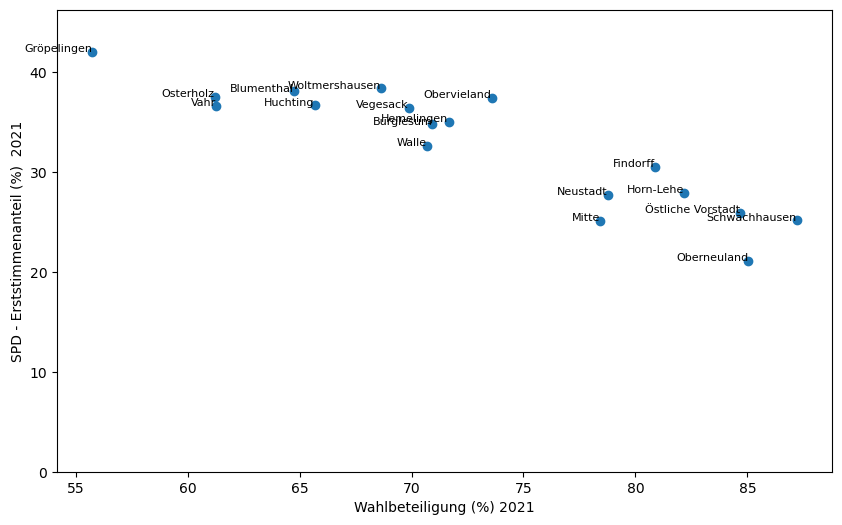

In [104]:
x1 = 'Wahlbeteiligung (%) 2021'
y = 'SPD - Erststimmenanteil (%)  2021'
correlation, p_value = pearsonr(daten[x1], daten[y])
print(f'Correlation: {correlation:.3f}')
print(f'p-value: {p_value:.3f}')

plt.figure(figsize=(10, 6))
plt.scatter(daten[x1], daten[y])

regions = daten.index
for i, region in enumerate(regions):
    plt.text(daten[x1][i], daten[y][i], region, fontsize=8, ha='right')

plt.ylim(0, daten[y].max() * 1.1)

plt.xlabel(x1)
plt.ylabel(y)


plt.show()


Correlation: 0.695
p-value: 0.001


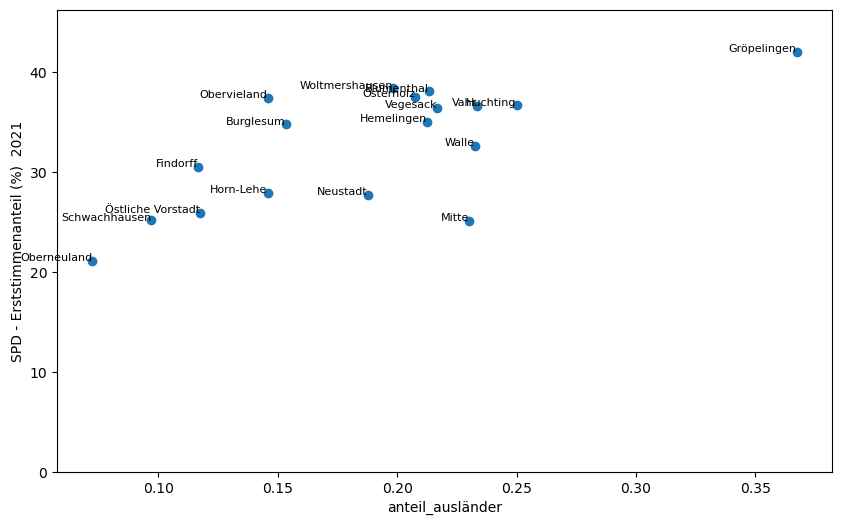

In [105]:
x2 = 'anteil_ausländer'
y = 'SPD - Erststimmenanteil (%)  2021'
correlation, p_value = pearsonr(daten[x2], daten[y])
print(f'Correlation: {correlation:.3f}')
print(f'p-value: {p_value:.3f}')

plt.figure(figsize=(10, 6))
plt.scatter(daten[x2], daten[y])

regions = daten.index
for i, region in enumerate(regions):
    plt.text(daten[x2][i], daten[y][i], region, fontsize=8, ha='right')

plt.ylim(0, daten[y].max() * 1.1)

plt.xlabel(x2)
plt.ylabel(y)


plt.show()


<a name="Stimmensplitting"></a>
Der nächste Plot (unten) zeigt eine Korrelation, wie man sie aus physikalischen Experimenten statt sozialwissenschaftlichen Daten erwartet. Anscheinend machen die Bremer keinen Unterschied zwischen Erst- und Zweitstimme, wenn sie SPD-Wähler sind; es gibt kaum <u>Stimmensplitting</u>.  

Correlation: 0.988
p-value: 0.000


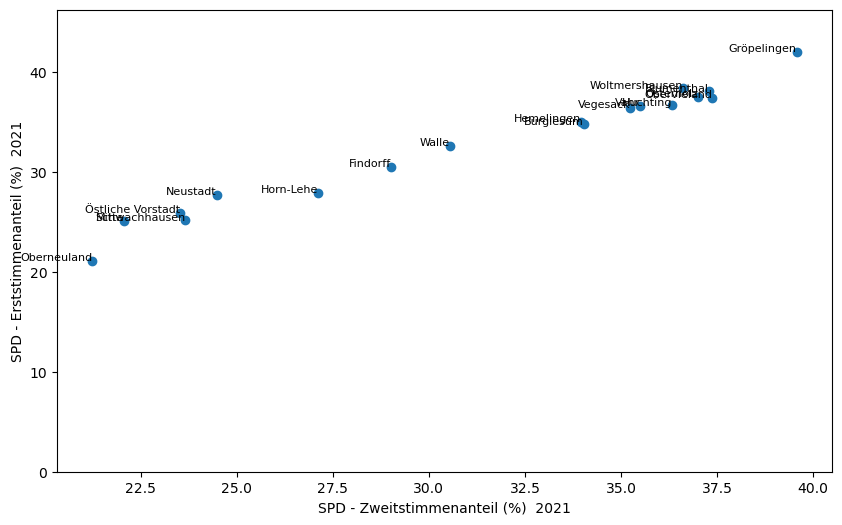

In [106]:
x3 = 'SPD - Zweitstimmenanteil (%)  2021'
y = 'SPD - Erststimmenanteil (%)  2021'
correlation, p_value = pearsonr(daten[x3], daten[y])
print(f'Correlation: {correlation:.3f}')
print(f'p-value: {p_value:.3f}')

plt.figure(figsize=(10, 6))
plt.scatter(daten[x3], daten[y])

regions = daten.index
for i, region in enumerate(regions):
    plt.text(daten[x3][i], daten[y][i], region, fontsize=8, ha='right')

plt.ylim(0, daten[y].max() * 1.1)

plt.xlabel(x3)
plt.ylabel(y)


plt.show()


#### a) <u>P-Werte</u> <a name="P-Werte"></a>
Die Korrelationen und die zugehörigen P-Werte sind über den Plots angegeben. Der P-Wert zeigt, wie wahrscheinlich es ist, eine Korrelation zu erhalten, die mindestens so stark ist, obwohl tatsächlich kein Zusammenhang besteht – also wie wahrscheinlich es ist, dass die Zahl zufällig zustande kam.

In diesem Fall kann ich den P-Wert berechnen, obwohl er hier eigentlich keine Bedeutung hat. Das liegt daran, dass ich nur deskriptive Statistiken der Gesamtbevölkerung anschaue. Es findet keine Inferenz von einer Stichprobe auf die Gesamtbevölkerung statt, die einen Signifikanztest erfordern würde. Beispielsweise braucht das Durchschnittseinkommen keinen P-Wert. Man kann es einfach berechnen. Wenn ich jedoch vom Durchschnitt einer Stichprobe auf den Durchschnitt der Gesamtbevölkerung schließen will, dann benötige ich einen P-Wert.

P-Werte könnten sinnvoll werden, wenn man die Wahldaten von 2021 als Stichprobe aus einer „Superpopulation“ über die Jahre hinweg betrachtet. Beispielsweise könnten die Wahldaten von 2017, 2021 und 2025 als Stichproben aus dieser Superpopulation angesehen werden. Dieses Modell setzt jedoch voraus, dass der Prozess, der die Daten erzeugt, über die Zeit stabil bleibt. Das ist bei Wahlen offensichtlich nicht der Fall! Nicht dieselben Menschen mit denselben Präferenzen stimmen bei jeder Wahl ab. Wenn das der Fall wäre, wären selbst kleine Änderungen in der Stimmenverteilung unwahrscheinlich. Wähler ändern aber ihre Meinung, was bedeutet, dass selbst große Unterschiede in den Wahlergebnissen nicht ungewöhnlich sind.

Im Folgenden tue ich aber normalerweise so, als handele es sich nicht um Daten der Gesamtbevölkerung, sondern um eine Stichprobe, um zu zeigen, wie ich in dieser (deutlich typischeren) Situation verfahren würde.

#### b) <u>Multiple Regression</u>  <a name="2,1,b"></a>
Eine einfache Regression zeigt den Zusammenhang zwischen zwei Variablen. Durch einen Plot mit Punkten wird eine Linie gelegt, die den kleinsten „durchschnittlichen“ vertikalen Abstand zu allen Punkten hat. Man kann nicht einfach den Durchschnitt der Abstände nehmen, da die Regression sonst immer eine horizontale Linie durch den Durchschnitt der abhängigen Variable (auf der y-Achse) ziehen würde – der durchschnittliche Abstand zum Durchschnitt ist nämlich immer Null. Stattdessen wird der Durchschnitt der quadrierten Abstände verwendet, also die „residual sum of squares“ (RSS).

Eine multiple Regression funktioniert im Grunde genauso, aber in höheren Dimensionen. Bei zwei unabhängigen Variablen wird eine zweidimensionale Ebene gefunden, die die geringste RSS durch die Daten hat. Bei drei Variablen wird eine dreidimensionale Hyperebene gefunden, die die geringste RSS hat, und so weiter.

Der Output der unteren Code-Zelle zeigt einige Ergebnisse einer multiplen Regression, bei der alle sozialen Variablen verwendet wurden, um den Erststimmenanteil der SPD vorherzusagen. Relevant ist der mittlere Block und die Zahl ganz oben rechts:

* R-squared oder „variance explained“ misst, wie viel der Varianz in der abhängigen Variable (Erststimmenanteil) durch die Regression erklärt wird. In diesem Fall bleiben nur noch etwa 5% der ursprünglichen Varianz übrig! Solch hohe Werte sind in den Sozialwissenschaften extrem selten und deuten eher darauf hin, dass etwas nicht stimmt.

* Der mittlere Block listet die Variablen auf. Zuerst „const“, der konstante Faktor in der linearen Gleichung – vergleichbar mit „a“ in y = a + bx –, dann „num_bevölkerung“ usw. In der Spalte „coef“ steht der Wert des Koeffizienten vor der Variable. Zum Beispiel hat die Arbeitslosenquote einen Koeffizienten von etwa 5,1. Das bedeutet, wenn wir alle anderen Variablen konstant halten und die Arbeitslosenquote um eine Einheit (hier einen Prozentpunkt) erhöhen, steigt der Erststimmenanteil der SPD im Durchschnitt um 5,1 Einheiten.

* Die einzigen anderen wichtigen Zahlen finden sich in der vierten Spalte unter „P > |t|“. Diese P-Werte der Koeffizienten zeigen, wie wahrscheinlich es ist, einen mindestens so großen Koeffizienten zufällig zu erhalten, wenn es in Wirklichkeit keinen Zusammenhang gibt und der Koeffizient also Null ist. Beispielsweise hätte der Koeffizient der Variable „num_ausländer“ einen P-Wert von 0,425. Das bedeutet, dass es eine sehr hohe Wahrscheinlichkeit gibt, dass der Koeffizient tatsächlich Null ist. Die Signifikanzgrenze wird üblicherweise bei 0,05 gezogen. 

In [107]:
model = sm.OLS(daten[y], sm.add_constant(Stadtteile.drop(['Häfen', 'Stadt Bremen']))).fit()
model.summary()

/Users/maxopperman/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     SPD - Erststimmenanteil (%)  2021   R-squared:                       0.952
Model:                                           OLS   Adj. R-squared:                  0.909
Method:                                Least Squares   F-statistic:                     22.17
Date:                               Wed, 28 Aug 2024   Prob (F-statistic):           4.73e-05
Time:                                       22:38:01   Log-Likelihood:                -29.755
No. Observations:                                 18   AIC:                             77.51
Df Residuals:                                      9   BIC:                             85.52
Df Model:                                          8                                         
Covariance Type:                           nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         89.2156     15.533      5.744      0.000      54.078     124.353
num_bevölkerung               -0.0003      0.000     -1.564      0.152      -0.001       0.000
num_ausländer                  0.0035      0.004      0.836      0.425      -0.006       0.013
anteil_ausländer             -49.9427    140.684     -0.355      0.731    -368.192     268.307
anteil_erstes_quint         -124.7755     50.417     -2.475      0.035    -238.827     -10.724
anteil_letztes_quint        -136.8041     23.779     -5.753      0.000    -190.597     -83.011
arbeitslosenquote_vor_wahl     5.1415      0.779      6.597      0.000       3.378       6.905
sgbII_leistungen_vor_wahl  -7.761e-06   8.83e-06     -0.879      0.402   -2.77e-05    1.22e-05
sgbII_pro_kopf                -0.6149      0.313     -1.965      0.081      -1.323       0.093
==============================================================================
Omnibus:                        2.325   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                0.701
Skew:                          -0.246   Prob(JB):                        0.704
Kurtosis:                       3.832   Cond. No.                     9.57e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### c) <u>Außreißer?</u>  <a name="2,1,c"></a>
Da es nur wenige Stadtteile gibt, warnt Python, dass der Test auf Kurtose nicht zuverlässig funktioniert (der Computer kann nicht überprüfen, ob die Fehler normalverteilt sind). Eine Alternative ist, einfach den Plot der Residuen zu betrachten – das sind die Abstände der Punkte von der Regressionslinie. Wenn diese Abstände nicht überall ungefähr gleich sind, deutet das auf Heteroskedastizität oder einen nicht-linearen Zusammenhang zwischen den unabhängigen und der abhängigen Variable hin. Der untenstehende Plot zeigt die „studentized residuals,“ da diese gleichzeitig Ausreißer anzeigen. Es gibt keine klaren Ausreißer, aber es könnte leichte Heteroskedastizität vorliegen; aufgrund der wenigen Punkte auf der linken Seite ist es schwer, das sicher zu beurteilen.

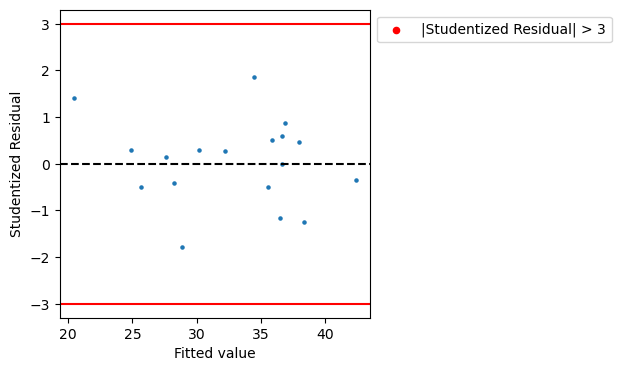

In [108]:
studentized_residuals = model.get_influence().resid_studentized_internal

ax = subplots(figsize=(4, 4))[1]
ax.scatter(model.fittedvalues, studentized_residuals, s=5)

ax.scatter(model.fittedvalues[abs(studentized_residuals) > 3],
           studentized_residuals[abs(studentized_residuals) > 3],
           color='red', s=20, label='|Studentized Residual| > 3')

ax.set_xlabel('Fitted value')
ax.set_ylabel('Studentized Residual')
ax.axhline(0, c='k', ls='--')
ax.axhline(3, c='r')
ax.axhline(-3, c='r')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

#### d) <u>Variance Inflation Factor</u>  <a name="2,1,d"></a>
In der Zusammenfassung der Regression wird in der zweiten Fußnote erwähnt, dass möglicherweise Multikollinearität vorliegt – also dass die unabhängigen Variablen stark untereinander korrelieren könnten.

Man kann die paarweisen Korrelationen aller Variablen in einer Matrix anzeigen lassen. Allerdings berücksichtigt diese Methode nicht den Fall, dass eine Variable $X$ zwar nicht stark mit den Variablen $A$, $B$ und $C$ korreliert, aber stark mit einer linearen Kombination dieser drei. Ein besseres Maß für diese Art der Multikollinearität ist der „Variance Inflation Factor“ (VIF). Er misst, wie stark jede einzelne Variable mit allen anderen Variablen gleichzeitig korreliert (anstatt nur paarweise Korrelationen zu betrachten).

Der VIF kann nie unter 1 liegen. Ein Wert von 10 deutet auf starke Multikollinearität hin, während ein Wert von 5 eine konservativere Schwelle darstellt. Diese Nuancen sind jedoch für die vorliegenden Daten völlig irrelevant, da die VIF-Werte jeden Rahmen sprengen:

In [109]:
X = sm.add_constant(Stadtteile.drop(['Häfen', 'Stadt Bremen']))

vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X.columns[1:])
vif

,vif
num_bevölkerung,16.180746
num_ausländer,805.004535
anteil_ausländer,500.668897
anteil_erstes_quint,28.992074
anteil_letztes_quint,21.711894
arbeitslosenquote_vor_wahl,87.169231
sgbII_leistungen_vor_wahl,769.636647
sgbII_pro_kopf,656.263832


Eine low-tech Herangehensweise wäre, einfach die Variablen mit dem höchsten VIF-Wert aus dem Modell zu nehmen, bis alle Werte unter 10 liegen. Da man den VIF des konstanten Faktors ignorieren kann, führt das zu diesem Modell:

In [110]:
X_reduced = X.drop(['num_ausländer', 'sgbII_pro_kopf', 'sgbII_leistungen_vor_wahl', 'anteil_erstes_quint'], axis=1)

vals = [VIF(X_reduced, i) for i in range(X_reduced.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X_reduced.columns)
vif

,vif
const,136.799558
num_bevölkerung,1.073771
anteil_ausländer,7.907788
anteil_letztes_quint,4.104336
arbeitslosenquote_vor_wahl,7.711057


Wenn es sich um eine Stichprobe handelte, stünde aber noch nicht fest, dass alle diese Variablen auch statistisch signifikant sind. Das tue ich im nächsten Schritt.

#### e) <u>ANOVA</u> <a name="2,1,e"></a>  
ANOVA steht für „Analysis of Variance“. Eine Anwendung von ANOVA ist es, alle Variablen eines Modells einem Hypothesentest zu unterziehen. Dabei wird überprüft, ob eine bestimmte Variable, wie zum Beispiel „anteil_ausländer“, signifikant ist. ANOVA vergleicht dazu den F-Wert des Modells mit der Variable und des Modells ohne diese Variable. Wenn die Erhöhung des F-Werts relativ zur Varianz der Residuen groß ist, deutet das darauf hin, dass die Variable signifikant ist.

Einfach gesagt: Wenn der P-Wert in der letzten Spalte in der nächsten Tabelle kleiner als 0,05 ist, ist die Variable wahrscheinlich nicht irrelevant.

In [111]:
# Renaming the first so that smf.ols does not complain.  
# Renaming the second for convenience later on.

daten_ = daten.copy()
daten_.rename(columns={'SPD - Erststimmenanteil (%)  2021': 'SPD_erststimmen_2021', 
                       'Wahlbeteiligung (%) 2021': 'wahlbeteiligung_2021'}, inplace=True)

formula = ' + '.join(X_reduced.columns)
model_test = smf.ols(f'SPD_erststimmen_2021 ~ {formula}', data=sm.add_constant(daten_)).fit()

anova_lm(model_test)

,df,sum_sq,mean_sq,F,PR(>F)
const,1.0,61.101088,61.101088,5.427964,0.036577
num_bevölkerung,1.0,17.529440,17.529440,1.557242,0.234080
anteil_ausländer,1.0,319.492236,319.492236,28.382346,0.000137
anteil_letztes_quint,1.0,70.650607,70.650607,6.276303,0.026327
arbeitslosenquote_vor_wahl,1.0,20.909779,20.909779,1.857537,0.196052
Residual,13.0,146.337411,11.256724,NaN,NaN


Es bleibt also nur der konstante Term, „anteil_ausländer“ und „anteil_letztes_quint;“ die letzte Variable bezieht sich auf das Fünftel mit dem *höchsten* Einkommen.  
Nun kann ich also eine Regression mit diesem kleineren Modell errechnen:

In [116]:
# Fit the model without insignificant predictors
formula_reduced = 'SPD_erststimmen_2021 ~ anteil_ausländer + anteil_letztes_quint'
model_reduced = smf.ols(formula_reduced, data=daten_).fit()
print(model_reduced.summary())


                             OLS Regression Results                             
Dep. Variable:     SPD_erststimmen_2021   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.644
Method:                   Least Squares   F-statistic:                     16.38
Date:                  Wed, 28 Aug 2024   Prob (F-statistic):           0.000169
Time:                          22:40:47   Log-Likelihood:                -46.606
No. Observations:                    18   AIC:                             99.21
Df Residuals:                        15   BIC:                             101.9
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

/Users/maxopperman/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Leider ist der P-Wert für „anteil_ausländer“ extrem hoch (0,895). Wenn ich jedoch ANOVA auf das kleinere Modell anwende (siehe Zelle direkt unten), stellen sich beide Variablen als signifikant heraus.

Das könnte darauf hindeuten, dass immer noch Multikollinearität im Modell vorhanden ist. Diese kann die Standardfehler erhöhen und die statistische „Power“ reduzieren. Aber wenn ich die Variance Inflation Factors (siehe Zelle einen weiter unten) neu berechne, sind sie nicht besonders hoch. Es scheint, dass diese weniger präzise Methode, signifikante Zusammenhänge per Hand zu finden, nicht weiterhilft. Daher werde ich andere Methoden zur Analyse verwenden müssen.

In [117]:
print('ANOVA results:')
print(anova_lm(model_reduced)['PR(>F)'])

ANOVA results:
anteil_ausländer        0.000232
anteil_letztes_quint    0.007136
Residual                     NaN
Name: PR(>F), dtype: float64


In [115]:
# VIF without insignificant predictors
X_reduced_more = X.drop(['num_ausländer', 'sgbII_leistungen_vor_wahl', 'anteil_erstes_quint', 'arbeitslosenquote_vor_wahl', 'num_bevölkerung'], axis=1)

vals = [VIF(X_reduced, i) for i in range(X_reduced_more.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X_reduced_more.columns)
print(vif)

                             vif
const                 136.799558
anteil_ausländer        1.073771
anteil_letztes_quint    7.907788
sgbII_pro_kopf          4.104336


## Faktorenanalyse <a name="2,2"></a>  
[Hoch](#toc)

Da die einfacheren Analysemethoden nur begrenzte Erkenntnisse geliefert haben, verwende ich nun zwei moderat komplexere Methoden.
&nbsp;&nbsp;&nbsp;&nbsp;Die Faktorenanalyse zielt darauf ab, latente Faktoren zu identifizieren, die alle anderen Variablen beeinflussen. Daher ist es sinnvoll, zunächst intuitiv darüber nachzudenken, was dieser latente Faktor bedeuten könnte. Die Variablen sind:  
1. Anteil Ausländer.  
2. Anteil im ärmsten Fünftel.  
3. Arbeitslosenquote.  
4. Wahlbeteiligung.  
5. SGB-II Leistungen pro Kopf.  
6. SGB-II Leistungen insgesamt.  
7. Anzahl Ausländer insgesamt.  
8. Anzahl Bevölkerung insgesamt.  
9. Anteil im reichsten Fünftel.

Die drei „insgesamt“-Variablen messen vor allem die Bevölkerungsanzahl. Es gibt keinen analytischen Grund anzunehmen, dass die Anzahl der Menschen in einem Stadtteil unabhängig von der Bevölkerungsdichte einen Einfluss auf das Wahlergebnis haben sollte. Wenn zwei identische Stadtteile zusammengelegt würden, würde die Bevölkerungszahl steigen, aber wir würden keine Veränderung im Wahlverhalten erwarten.  
&nbsp;&nbsp;&nbsp;&nbsp;Es bleiben also die anteilsmäßigen Variablen. Jedoch scheint mir intuitiv der Anteil im reichsten Fünftel qualitativ anders zu sein als die ersten fünf Variablen (es wird sich tatsächlich gleich herausstellen, dass diese fünf Variablen die beste Kombination sind).  
&nbsp;&nbsp;&nbsp;&nbsp;Was verbindet diese Variablen? Vielleicht ein Konzept wie „Sozialschwäche“ oder eine „prekäre Lage“. Der genaue Name des Faktors ist für die Analyse nicht entscheidend, aber es scheint, als ob es einen zugrunde liegenden Faktor geben könnte. 



#### a) <u>Sind die Daten für Faktorenanalyse geeignet?</u> <a name="2,2,a"></a>

Man sollte sich nicht nur auf Spekulationen und Eindrücke verlassen. Daher überprüfe ich als nächstes, ob die Daten tatsächlich für eine Faktorenanalyse geeignet sind.

In [128]:
# Checking whether the data are even suitable for factor analysis

X_clean = pd.merge(X.drop(columns=['const', 
                                   'anteil_letztes_quint', 
                                   'num_ausländer', 
                                   'sgbII_leistungen_vor_wahl', 
                                   'num_bevölkerung']), 
                   daten_['wahlbeteiligung_2021'] , 
                   on='region')

kmo_all, kmo_model = calculate_kmo(X_clean)
print('KMO Test: ', round(kmo_model, 3))

bartlett_test = calculate_bartlett_sphericity(X_clean)
print('Bartlett’s test: ', bartlett_test[1])
print()
print('Benutzte Variablen:')
print(', '.join(X_clean.columns))

KMO Test:  0.872
Bartlett’s test:  1.4428985414960861e-24

Benutzte Variablen:
anteil_ausländer, anteil_erstes_quint, arbeitslosenquote_vor_wahl, sgbII_pro_kopf, wahlbeteiligung_2021


Das *Kaiser-Meyer-Olkin* Kriterium misst den Anteil der Varianz, die durch gemeinsame Faktoren erklärt werden kann. Wenn zwei Variablen zwar miteinander korrelieren, aber nicht mit anderen Variablen, wird dies vom KMO-Kriterium nicht berücksichtigt. Die Annahme ist ja gerade, dass es gemeinsame Faktoren gibt, die alle Variablen beeinflussen. Wenn also nicht alle Variablen miteinander korrelieren, deutet das darauf hin, dass solche gemeinsamen Faktoren möglicherweise nicht existieren.  
&nbsp;&nbsp;&nbsp;&nbsp;KMO produziert Werte in $[0,1]$ und sollte nahe bei 1 liegen. Ein Wert unter 0,8 wird als mittelmäßig angesehen, und ein Wert unter 0,6 spricht gegen die Durchführung einer Faktorenanalyse. 
&nbsp;&nbsp;&nbsp;&nbsp;*Bartletts* Test produziert u. a. einen P-Wert, der nahe bei Null liegen sollte. Das Ergebnis des Tests hier hat 23 Nachkommastellen vor der ersten Eins. Die Notation „`e-24`“ entspricht $\times 10^{-24}$.  

Diese Auswahl der Variablen basiert auf einem trial-and-error-Verfahren, geleitet von der Überlegung oben, wie der latente Faktor aussehen könnte. Keine andere Kombination liefert einen höheren KMO-Wert.

#### b) <u>Wie viele Faktoren?</u> <a name="2,2,b"></a>

Eine etwas analytischere Methode, um zu entscheiden, wie viele Faktoren es gibt, ist es, den sogenannten „Scree“-Plot anzugucken:

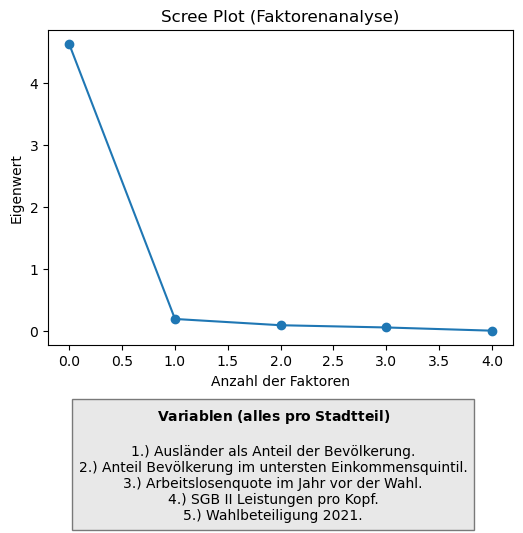

In [903]:
# Performing Factor Analysis
fa = FactorAnalyzer()
fa.fit(X_clean)

ev, v = fa.get_eigenvalues()

# Scree Plot
plt.figure(figsize=(6, 5))
plt.plot(ev, 'o-')
plt.xlabel('Anzahl der Faktoren')
plt.ylabel('Eigenwert')
plt.title('Scree Plot (Faktorenanalyse)')

variables = '\n'.join([
    r'$\bf{Variablen\ (alles\ pro\ Stadtteil)\ }$',
    '',
    '1.) Ausländer als Anteil der Bevölkerung.',
    '2.) Anteil Bevölkerung im untersten Einkommensquintil.',
    '3.) Arbeitslosenquote im Jahr vor der Wahl.',
    '4.) SGB II Leistungen pro Kopf.',
    '5.) Wahlbeteiligung 2021.',
])

plt.figtext(0.5, -0.1, variables, ha="center", fontsize=10, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})
plt.subplots_adjust(bottom=0.25)

plt.show()


Man schaut, wo der „Ellenbogen“ im Graph ist, also der Punkt, nach dem der Plot flach wird.<sup>†</sup> Die y-Achse mag etwas kryptisch wirken, sie misst prinzipiell, wie viel der Varianz erklärt wird. Anscheinend erklärt der erste Faktor fast die gesamte Varianz!  
Wie viel er genau erklärt, wird in der nächsten Zelle ausgerechnet:

<br>
<hr style="width: 10%; text-align: left; margin-left: 0;">
<small><sup>†</sup>Wenn ich an dieser Stelle einen Scree-Plot mit allen sozialen Variablen produziere, sieht man einen starken ersten Faktor und einen deutlich schwächeren zweiten. Der zweite Faktor fängt die drei „insgesamt“ Variablen ein, die die Gesamtbevölkerung beschreiben.</small>

In [814]:
# Choose the number of factors based on the scree plot
num_factors = 1

fa_ = FactorAnalyzer(n_factors=num_factors)
fa_.fit(X_clean)

# Loadings and variance
factor_loadings = fa_.loadings_
print('Factor Loadings:\n', factor_loadings)

explained_variance = fa_.get_factor_variance()[1]
print("Explained Variance: ", explained_variance)


Factor Loadings:
 [[-0.95876235]
 [-0.94796932]
 [-0.9794939 ]
 [-0.98996176]
 [ 0.88025438]]
Explained Variance:  [0.90643029]


/Users/maxopperman/anaconda3/lib/python3.11/site-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


Die „Factor Loadings“ zeigen, wie stark die einzelnen Variablen mit dem ersten Faktor korrelieren. Die Wahlbeteiligung, die letzte Variable, hat als einzige eine positive Korrelation, was intuitiv Sinn ergibt: *Mehr* SGB-II Leistungen pro Kopf bedeuten eine prekärere Lage aber dasselbe gilt für *weniger* Wahlbeteiligung. Das Vorzeichen muss wechseln.  
&nbsp;&nbsp;&nbsp;&nbsp;Die „Explained Variance“ ist genau das, was der Name sagt. Anscheinend erklärt der erste Faktor 91% der Varianz in den fünf Variablen.
 

#### c) <u>Regression mit Factor Scores</u> <a name="2,2,c"></a>

Die fünf Variablen sind aber unsere unabhängigen Variablen und wir wollen ja die abhängige Variable, den Erststimmenanteil der SPD, erklären. Dafür sind die „Factor Scores“ nützlich. Sie zeigen für jeden Stadtteil an, wie stark der latente Faktor, also die Sozialschwäche oder Prekarität, zum Ausdruck kommt. Mit diesen Scores kann man dann wieder eine einfache Regression errechnen:

In [847]:
# Getting the factor scores
factor_scores = fa_.transform(X_clean)
X_factor = pd.DataFrame({'Factor Score':factor_scores.flatten()}, index=X_clean.index) 

# Fitting the regression model
X_factor = sm.add_constant(X_factor)
y_factor = daten_['SPD_erststimmen_2021']
model_factor = sm.OLS(y_factor, X_factor).fit()

print(model_factor.summary())

                             OLS Regression Results                             
Dep. Variable:     SPD_erststimmen_2021   R-squared:                       0.602
Model:                              OLS   Adj. R-squared:                  0.577
Method:                   Least Squares   F-statistic:                     24.20
Date:                  Sat, 24 Aug 2024   Prob (F-statistic):           0.000154
Time:                          18:00:40   Log-Likelihood:                -48.738
No. Observations:                    18   AIC:                             101.5
Df Residuals:                        16   BIC:                             103.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           32.7353     

/Users/maxopperman/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Der $R^2$-Wert ganz rechts oben zeigt an, dass der Faktor etwa 60% der Varianz in den Erststimmenanteilen der SPD zwischen den Stadtteilen erklärt. Die P-Werte sind bedeutungslos, aber wenn es sich um eine Stichprobe handelte, wäre der Effekt des Faktors hochsignifikant, da $p < 0.0005$. 

#### d) <u>Signifikanz</u> <a name="Signifikanz"></a>
„Signifikanz“ bedeutet in diesem und allen anderen Zusammenhängen nie, dass ein Koeffizient oder ein Unterschied praktisch relevant oder bedeutend ist. Signifikanz bezieht sich stets nur auf die Wahrscheinlichkeit, dass der Wert eines Koeffizienten per Zufall Zustande gekommen wäre, wenn es eigentlich keinen Zusammenhang gibt. Ein „hochsignifikanter“ Wert bedeutet lediglich, dass es eine sehr geringe Wahrscheinlichkeit gibt, diesen extremen Wert zu erhalten, obwohl in Wirklichkeit kein Zusammenhang besteht.  
&nbsp;&nbsp;&nbsp;&nbsp;Zum Beispiel könnte ein Unterschied von 0,004 Punkten im Notendurchschnitt von Abiturienten zwischen Männern und Frauen (z. B. 2,1 und 2,104) in einer Stichprobe, die nur *groß genug* ist, hochsignifikant sein, auch wenn der Unterschied praktisch irrelevant ist. Wenn es diesen Unterschied im Durchschnitt *aller* Abiture statt nur in einer Stichprobe gibt, ist das Konzept von „Signifikanz“ nicht anwendbar, da keine Unsicherheit in unseren Daten ist.

#### e) <u>Auswertung</u> <a name="2,2,e"></a>  
Obwohl das Modell auf den Erststimmen trainiert wurde, zeigt der Plot unten, dass seine Leistung beim Vorhersagen des Zweitstimmenanteils nicht viel schlechter ist. Die Daten liefern jedoch keine klare Antwort darauf, in welche Richtung die Kausalität geht:

* Beeinflusst der Faktor „Sozialschwäche“ das politische Verhalten von SPD-Wählern so stark, dass es kaum einen Unterschied zwischen Erst- und Zweitstimmen gibt?
* Oder gibt es aus anderen Gründen kein Stimmensplitting, sodass der Faktor zufällig beide Stimmenanteile erklärt?
Die Tabellen unter dem Plot zeigen, wie viel des Unterschieds in den Stimmenanteilen zwischen den Stadtteilen für verschiedene Parteien durch den Faktor „Sozialschwäche“ erklärt wird. Die relevante Zeile ist jeweils die letzte, die „R^2“ heißt.

Etwa 60% der Unterschiede bei SPD- und AfD-Erststimmen werden durch diesen Faktor erklärt, während es etwa ein Viertel für die Grünen und FDP ist – allerdings mit entgegengesetztem Vorzeichen. Das Vorzeichen kann man dem $R^2$ nicht ansehen, aber zwei Zeilen darüber findet man die Korrelation, die auch negativ sein kann. In sozial schwächeren Stadtteilen sind die Stimmenanteile für SPD und AfD höher, während sie für FDP und Grüne niedriger sind.  
&nbsp;&nbsp;&nbsp;&nbsp;Das bedeutet jedoch nicht unbedingt, dass SPD- und AfD-Wähler sich ähneln oder gegeneinander ausgetauscht werden können. Wir analysieren die Stadtteile, in denen sie leben. Es könnte sein, dass es zwei Typen von Wählern gibt, die unterschiedlich auf soziale Prekarität reagieren oder diese verursachen. SPD- und AfD-Wähler könnten sich beide von sozialer Schwäche angezogen fühlen oder gemeinsam auf ähnliche Weise soziale Probleme in ihren Stadtteilen hervorrufen.  
&nbsp;&nbsp;&nbsp;&nbsp;Dass bei der Linken kein starker Zusammenhang zwischen dem Faktor und ihren Stimmen zu erkennen ist, könnte auf zwei entgegengesetzte Tendenzen hinweisen: Menschen in sehr prekären und sehr wohlhabenden Stadtteilen wählen sie möglicherweise, während der Effekt bei anderen Parteien homogener ist.

Diese Korrelationen zeigen jedoch nicht, wie intensiv der Wettkampf um Stimmen zwischen den Parteien ist. Wenn SPD- und AfD-Wähler sich tatsächlich nicht direkt substituieren lassen, bedeutet eine Stimme mehr für die AfD nicht zwangsläufig eine Stimme weniger für die SPD. Auch wenn Grüne und SPD-Wähler unterschiedlich auf soziale Schwäche reagieren, könnte in jedem einzelnen Stadtteil eine Stimme mehr für die Grünen trotzdem eine Stimme weniger für die SPD bedeuten.

Diese Frage werde ich im nächsten Teil weiter untersuchen.

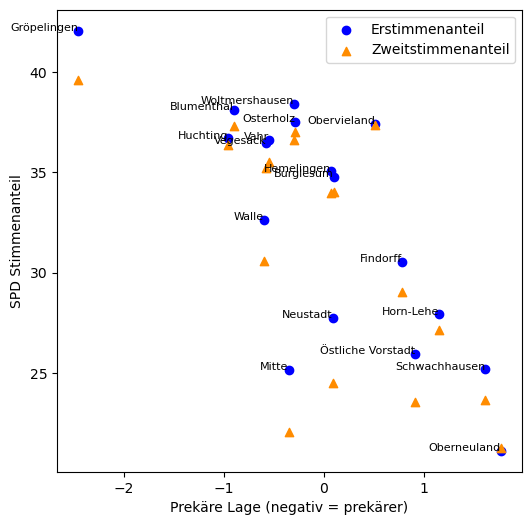

In [904]:
plt.figure(figsize=(6, 6))
plt.scatter(X_factor['Factor Score'], y_factor, label='Erstimmenanteil', color='blue')
plt.scatter(X_factor['Factor Score'], daten['SPD - Zweitstimmenanteil (%)  2021'], marker='^', label='Zweitstimmenanteil', color='darkorange')

plt.xlabel('Prekäre Lage (negativ = prekärer)')
plt.ylabel('SPD Stimmenanteil')

plt.legend(loc='best')


regions = X_factor.index
for i, region in enumerate(regions):
    plt.text(X_factor['Factor Score'][i], y_factor[i], region, fontsize=8, ha='right')

plt.show()


In [854]:
parties = ['SPD', 'CDU', 'GRÜNE', 'DIE LINKE', 'FDP', 'AfD']
result_types = ['Coefficient', 'Correlation', 'P-Value', 'R^2']

Parteien_factor_erststimmen = pd.DataFrame(index=result_types)
Parteien_factor_zweitstimmen = pd.DataFrame(index=result_types)

for ordinal in ['Erst', 'Zweit']:
    for party in parties:
        y_party = daten[f'{party} - {ordinal}stimmenanteil (%)  2021']
        model_party = sm.OLS(y_party, X_factor).fit()
        
        coefficient_party = model_party.params['Factor Score']
        p_value_party = model_party.pvalues['Factor Score']
        correlation_party, _ = pearsonr(X_factor['Factor Score'], y_party)
        rsquared = correlation_party ** 2

        if ordinal == 'Erst':
            Parteien_factor_erststimmen[party] = [
                coefficient_party,
                correlation_party,
                p_value_party,
                rsquared]
        else:
            Parteien_factor_zweitstimmen[party] = [
                coefficient_party,
                correlation_party,
                p_value_party,
                rsquared]

Parteien_factor_erststimmen = Parteien_factor_erststimmen.round(3)
Parteien_factor_zweitstimmen = Parteien_factor_zweitstimmen.round(3)

In [855]:
Parteien_factor_erststimmen

,SPD,CDU,GRÜNE,DIE LINKE,FDP,AfD
Coefficient,-4.487,2.717,4.187,-0.427,0.958,-2.539
Correlation,-0.776,0.390,0.518,-0.107,0.512,-0.753
P-Value,0.000,0.110,0.028,0.672,0.030,0.000
R^2,0.602,0.152,0.268,0.011,0.262,0.568


In [856]:
Parteien_factor_zweitstimmen

,SPD,CDU,GRÜNE,DIE LINKE,FDP,AfD
Coefficient,-4.235,2.032,4.464,-0.123,1.481,-2.381
Correlation,-0.701,0.346,0.497,-0.032,0.578,-0.732
P-Value,0.001,0.159,0.036,0.900,0.012,0.001
R^2,0.491,0.120,0.247,0.001,0.334,0.535


## LASSO und Validierung <a name="2,3"></a>  
[Hoch](#toc)

Der Unterschied zwischen LASSO (Least Absolute Shrinkage and Selection Operator) und einer normalen Regression liegt in der Art und Weise, wie die Koeffizienten behandelt werden. Formal minimiert LASSO folgenden Ausdruck:
$$
\text{RSS} + \lambda\sum^p_{j=1}\lvert \beta_j \rvert
$$
„RSS“ ist immer noch die „residual sum of squares,“ die den Abstand aller Punkte von der Regressionslinie misst. Die $\beta_j$ sind die Koeffizienten, von denen es so viele gibt, wie unsere Tabelle Spalten hat. Eine „Tabelle“ in der Statistik heißt eigentlich Designmatrix, und wenn man die im Allgemeinen behandelt, sagt man normalerweise es sei eine $n\times p$ Matrix, also eine Matrix mit $n$ Zeilen und $p$ Spalten. Daher kommt das $p$ auf dem Summenzeichen.    
&nbsp;&nbsp;&nbsp;&nbsp;Eine normale Regression minimiert einfach die RSS. Aber LASSO fügt dem noch die Gesamtgröße der Koeffizienten hinzu; je mehr Koeffizienten es gibt und je größer sie sind, desto kleiner müsste die RSS sein, um das auszugleichen. Der Faktor $\lambda$ kontrolliert, wie stark das Modell für viele und große Koeffizienten bestraft wird (im Englischen tatsächlich „penalty term“).  
&nbsp;&nbsp;&nbsp;&nbsp;Ein letztes Detail ist, dass der absolute Betrag der Koeffizienten in die Summe kommt. Man könnte auch die quadrierten Koeffizienten nehmen, dann wäre es eine Ridge-Regression, aber mit dem absoluten Betrag bekommt LASSO einige Koeffizienten auf genau Null, statt nur sehr klein. Deshalb ist LASSO in der Lage, die wichtigsten variablen auszusuchen, während z. B. Ridge fast immer alle Variablen im Modell lässt. LASSO funktioniert daher am besten, wenn tatsächlich nur eine Handvoll Variablen wichtig sind.


#### a) <u>Das LASSO-Modell anpassen</u> <a name="2,3,a"></a>  
Als nächstes passe ich eine LASSO-Regression auf die gesamten Daten an: Die sozialen Daten und auch die Stimmenergebnisse der verschiedenen Parteien und deren Veränderung von 2017 auf 2021.

<br>

<small>Zwei technische Besonderheiten; kann ohne Verständnisverlust übersprungen werden:  
&nbsp;&nbsp;&nbsp;&nbsp;Da für LASSO die Größe der Koeffizienten eine Rolle spielt, sollten die Daten normalisiert werden. Wenn ich militärische Macht mit einer Regression messen wollte und Anzahl der Soldaten und Militärausgaben in Euro als Variablen hätte, würde die erste Variable Zahlen von mehreren Hunderttausend annehmen aber die zweite von mehreren Milliarden. Normaler Regression ist das egal aber LASSO könnte die Ausgaben unterbewerten. Nach einer Normalisierung werden alle Variablen in Standardabweichungen von ihrem Mittelwert gemessen.  
&nbsp;&nbsp;&nbsp;&nbsp;Zweitens ist das $\lambda$ ein Hyperparameter, der getunt werden muss. LASSO weiß nicht automatisch, was der beste $\lambda$-Wert ist. Das passiert hier dadurch, dass ich den `LassoCV`-*estimator* aus `scikit-learn` benutze statt des normalen `Lasso`. „CV“ steht für „*cross validation*,“ eine äußerst clevere und simple Methode, um ohne einen extra Datensatz zum Testen des Modells auszukommen: Die Daten werden in z. B. Fünftel geteilt, und dann werden immer vier Teile benutzt, um das Modell zu trainieren, und der fünfte, um das Modell zu testen. Das macht man mit allen fünf Teilen und nimmt den Durchschnitt der Ergebnisse.</small>

In [135]:
daten.columns
daten_lasso = daten.drop(columns=['SPD - Erststimmenanteil (%)  2021', 
                                  'SPD - Erststimmenanteil: Veränderung 2021-2017', 
                                  'SPD - Zweitstimmenanteil (%)  2021', 
                                  'SPD - Zweitstimmenanteil: Veränderung 2021-2017'])
y_lasso = daten['SPD - Erststimmenanteil (%)  2021']

In [136]:
# Pipeline for LASSO
lasso_cv = LassoCV(cv=5, max_iter=10000)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', lasso_cv)
])

# Fit the model
pipeline.fit(daten_lasso, y_lasso)

# Get the best alpha (penalty term) and the corresponding model
best_alpha = pipeline.named_steps['lasso_cv'].alpha_
best_model = pipeline.named_steps['lasso_cv']

# Uncomment as necessary. Cluttering up my analysis right now.
'''
print(f"Best alpha (penalty term): {best_alpha}")
print("Coefficients:", best_model.coef_)
'''

# If you want to evaluate the performance:
y_pred = pipeline.predict(daten_lasso)
rmse = np.sqrt(mean_squared_error(y_lasso, y_pred))
print(f"Root Mean Squared Error: {rmse:.3f}")


Root Mean Squared Error: 0.777


Der "Root Mean Square Error" (RMSE) zeigt, wie gut das LASSO-Modell die Erststimmenanteile vorhersagt. Der RMSE von 0,777 bedeutet also, dass das Modell im Durchschnitt etwa 0,777 Prozentpunkte vom tatsächlichen Wert der Erststimmenanteile in den Stadtteilen abweicht. Das Modell trifft die Realität also ziemlich genau!  
&nbsp;&nbsp;&nbsp;&nbsp;Nun ist es Zeit, die tatsächlichen Koeffizienten anzusehen. Im Gegensatz zur normalen Regression haben die Koeffizienten bei LASSO keine direkte Bedeutung, da alle Variablen normalisiert wurden. Ihre relative Größe gibt jedoch an, welche Variablen am wichtigsten sind, und das Vorzeichen zeigt an, ob eine höhere Ausprägung der Variablen mit mehr oder weniger Stimmen verbunden ist:

In [137]:
coef_df = pd.DataFrame({
    'Variable': daten_lasso.columns,
    'Coefficient': best_model.coef_
})

#print(lasso_cv.intercept_)
print(coef_df)


                                             Variable  Coefficient
0                                     num_bevölkerung     0.264051
1                                       num_ausländer     0.000000
2                                    anteil_ausländer     0.076958
3                                 anteil_erstes_quint     0.491252
4                                anteil_letztes_quint    -0.849459
5                          arbeitslosenquote_vor_wahl     0.000000
6                           sgbII_leistungen_vor_wahl    -0.000000
7                                      sgbII_pro_kopf    -0.000000
8                            Wahlbeteiligung (%) 2021    -0.000000
9              Wahlbeteiligung: Veränderung 2021-2017    -0.983569
10                  CDU - Erststimmenanteil (%)  2021    -0.000000
11     CDU - Erststimmenanteil: Veränderung 2021-2017    -0.000000
12            DIE LINKE - Erststimmenanteil (%)  2021    -1.200486
13  DIE LINKE - Erststimmenanteil: Veränderung 202...     0.77

#### b) <u>Interpretation des LASSO-Modells</u> <a name="2,3,b"></a>

Es wird sich gleich herausstellen, dass diese Koeffizienten leider nicht besonders stabil sind. Aber *exemplum gratia* tue ich so, als seien sie stabil, und erkläre, wie man diese Koeffizienten interpretieren könnte:  

1. Die <u>Wahlbeteiligung</u> hat einen Koeffizienten von Null, aber ihre *Veränderung* hat einen moderat negativen Koeffizienten. Das deutet darauf hin, dass der SPD-Wählerblock stabiler ist als der anderer Parteien. Wenn die Wahlbeteiligung steigt und die rohe Anzahl der SPD-Wähler zunimmt, müssen die Stimmen anderer Parteien noch stärker ansteigen, da der SPD-Anteil bei höherer Wahlbeteiligung sinkt. Dies könnte darauf hinweisen, dass Wähler anderer Parteien wankelmütiger oder leichter zu mobilisieren sind.

2. Der Erststimmenanteil <u>der Linken</u> hat einen negativen Koeffizienten, aber die Veränderung dieses Anteils einen moderat positiven. Was auch immer dazu führt, dass Wähler der Linken zur Wahl gehen, führt auch dazu, dass SPD-Wähler zur Wahl gehen (der positive Koeffizient). Aber unter sonst gleichen Bedingungen, einschließlich der Gesamtwahlbeteiligung (!), bedeutet eine Stimme mehr für die Linke eine Stimme weniger für die SPD, da es direkte Konkurrenz gibt (der negative Koeffizient). Es könnte auch sein, dass die Linke, unter sonst gleichen Bedingungen, Stimmen von der SPD stiehlt, aber *noch mehr* von der Konkurrenz stiehlt; dann könnte ein erhöhter Stimmenanteil für die Linke weniger für die SPD bedeuten, aber „noch mehr weniger“ für die Konkurrenz außerhalb von Linke und SPD.

3. Der Koeffizient für den Zweitstimmenanteil <u>der AfD</u> ist Null, was darauf hindeutet, dass es keine direkte Konkurrenz zwischen SPD und AfD um Wählerstimmen gibt. Die Veränderung der AfD-Zweitstimmen hat einen negativen Koeffizienten, was darauf hindeutet, dass AfD-Wähler durch andere Faktoren mobilisiert werden, die auch die SPD-Wähler beeinflussen. Was auch immer einen größeren Anstieg der Wahlbeteiligung der AfD verursacht (also ein Anstieg von 0 auf 30 statt von 20 auf 30), führt auch zu einer geringeren Wahlbeteiligung für die SPD oder zu mehr Stimmen für andere Parteien.

4. Die Zweitstimmenanteile für <u>FDP und Grüne</u> haben stark negative Koeffizienten, während die Veränderung dieser Anteile Koeffizienten von Null hat. Das deutet auf starken Wettbewerb zwischen der SPD und diesen Parteien hin: In Stadtteilen, in denen die Grünen oder die FDP mehr Stimmen erhalten, hat die SPD tendenziell weniger Stimmen. Die Faktoren, die den Stimmenanteil der Grünen oder der FDP im Laufe der Zeit erhöhen oder verringern, haben jedoch keinen bedeutenden Einfluss auf den Stimmenanteil der SPD. (Das ist das intuitive Ergebnis. Warum sollte die Veränderung statt der tatsächliche Stimmenanteil irgendeine Rolle spielen?)  

Jetzt passe ich ein LASSO-Modell nur auf die Stimmenergebnisse an:

In [138]:
daten_lasso_stimmen = daten_lasso.iloc[:, 8:]

In [139]:
pipeline.fit(daten_lasso_stimmen, y_lasso)
y_pred_stimmen = pipeline.predict(daten_lasso_stimmen)
rmse_stimmen = np.sqrt(mean_squared_error(y_lasso, y_pred_stimmen))
print(f"Root Mean Squared Error: {rmse_stimmen:.3f}")
best_model = pipeline.named_steps['lasso_cv']

coef_df_stimmen = pd.DataFrame({
    'Variable': daten_lasso_stimmen.columns,
    'Coefficient': best_model.coef_
})

print(coef_df_stimmen)

Root Mean Squared Error: 0.164
                                             Variable  Coefficient
0                            Wahlbeteiligung (%) 2021    -0.624041
1              Wahlbeteiligung: Veränderung 2021-2017     0.000000
2                   CDU - Erststimmenanteil (%)  2021    -1.520083
3      CDU - Erststimmenanteil: Veränderung 2021-2017    -0.104563
4             DIE LINKE - Erststimmenanteil (%)  2021    -2.522169
5   DIE LINKE - Erststimmenanteil: Veränderung 202...     0.557489
6                 GRÜNE - Erststimmenanteil (%)  2021    -0.000000
7    GRÜNE - Erststimmenanteil: Veränderung 2021-2017    -0.000000
8                   AfD - Erststimmenanteil (%)  2021    -0.000000
9      AfD - Erststimmenanteil: Veränderung 2021-2017    -0.000000
10                  FDP - Erststimmenanteil (%)  2021    -0.000000
11     FDP - Erststimmenanteil: Veränderung 2021-2017    -0.000000
12                 CDU - Zweitstimmenanteil (%)  2021    -2.239762
13    CDU - Zweitstimmenanteil:

<a name="Zweitstimmen-Konkurrenz"></a>
Der RMSE von 0,164 ist etwas besser als bei dem anderen Modell. Das liegt vermutlich daran, dass in diesem Modell mehr Koeffizienten ungleich Null sind. Das ist allerdings nicht unbedingt positiv, da das Modell dadurch eher „überangepasst“ ist, was sich gleich zeigen wird.

Im Allgemeinen sind die Koeffizienten nicht besonders stabil. Viele Koeffizienten sind größer oder kleiner als im ersten Modell oder haben sogar andere Vorzeichen. Deshalb sollte man die Ergebnisse nicht zu genau analysieren; auch meine Interpretationen der Koeffizienten oben sind daher in der Realität nicht signifikant. 

Grob lässt sich sagen, dass es bei den Zweitstimmen <u>härtere Konkurrenz</u> gibt – bis auf bei der Linken –, da bei den Erststimmen häufiger Koeffizienten Null sind. Auch zeigt sich, dass die Anteile wichtiger sind als die Veränderungen (warum auch nicht? Genau so hätte man es erwartet). Außerdem variiert die Intensität der Konkurrenz zwischen den Parteien und der SPD nicht besonders stark, da die Koeffizienten meist um $-2,5$ liegen, mit Ausnahme des Koeffizienten für den Zweitstimmenanteil der Grünen.

<a name="Wahlbeteiligung2"></a>
Der Koeffizient der <u>Wahlbeteiligung</u> ist mal Null, mal ungleich Null, was darauf hindeutet, dass sie relativ zu anderen Faktoren weniger entscheidend ist, obwohl die einfache Korrelation stark negativ ist (siehe ganz am [Anfang der Analyse](#Wahlbeteiligung1)). Das deutet darauf hin, dass diese Korrelation durch Multikollinearität verursacht wird und nicht „echt“ ist. LASSO ist robuster gegenüber Multikollinearität und zeigt korrekt, dass die stark negative Korrelation keine unabhängigen Informationen liefert.

#### c) <u>Validierung der Modelle</u> <a name="2,3,c"></a>  
Der beste Test eines statistischen Modells ist, es auf einen frischen Datensatz loszulassen; auch der Grund, warum Replikation von Experimenten so wichtig ist, denn jedes neue Experiment produziert vorher noch nie dagewesene Daten. Ich könnte die Modelle an den Wahldaten 2023 (oder 2017) testen. Stattdessen wähle ich die typischere (weil einfachere) Variante, meinen Datensatz in zwei Teile aufzusplitten. Ein Fünftel wird mein Testdatensatz, auf dem rest werden die Modelle trainiert.  

Die zwei Modelle sind das volle Modell mit allen sozialen Daten und den Wahlergebnissen für die Parteien und das kleinere Modell mit nur den Wahlergebnissen:

In [140]:
X_train, X_test, y_train, y_test = train_test_split(daten_lasso, y_lasso, test_size=0.2, random_state=42)
X_train_, X_test_, y_train_, y_test_ = train_test_split(daten_lasso_stimmen, y_lasso, test_size=0.2, random_state=42)

# How well does the full model perform
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
rmse_full = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error, full model: {rmse_full:.3f}")

# How well does the smaller model perform
pipeline.fit(X_train_, y_train_)

y_pred_ = pipeline.predict(X_test_)
rmse_small = np.sqrt(mean_squared_error(y_test_, y_pred_))
print(f"Root Mean Squared Error, small model: {rmse_small:.3f}")

Root Mean Squared Error, full model: 1.751
Root Mean Squared Error, small model: 1.821


Obwohl das kleinere Modell oben einen geringeren Fehler aufwies, zeigt sich hier, dass es auf den ungesehenen Daten einen größeren Fehler hat. Dies deutet darauf hin, dass das kleinere Modell überangepasst ist!  
&nbsp;&nbsp;&nbsp;&nbsp;In allen Daten gibt es immer etwas „noise,“ also zufällige Variation. Wenn statistische Modelle zu genau auf ihre Trainingsdaten angepasst werden, interpretieren sie dieses „noise“ fälschlicherweise als Signal oder Information. Bei der Vorhersage neuer Daten verwenden sie dann teilweise dieses „noise,“ was zwangsläufig zu schlechteren Vorhersagen führt, da „noise“ per Definition nicht informativ ist.  

Wie kann es sein, dass ein kleineres Modell schlimmer überangepasst wird, als ein größeres? Wie oben erwähnt, hat das volle Modell tatsächlich *weniger* Koeffizienten, die ungleich Null sind. Daher ist das volle Modell effektiv kleiner als das „kleine“ Modell.

#### d) <u>Verstehen vs. Voraussagen</u> <a name="2,3,d"></a>  
An dieser Stelle lohnt es sich auch, auf den Unterschied zwischen Inferenz und Voraussagen aufmerksam zu machen. Das lineare Modell, das die multiple Regression am Anfang repräsentierte, war letztendlich schwer zu interpretieren, da die unabhängigen Variablen zu stark miteinander korrelierten. Es war unklar, welche Variablen signifikant sind und welche aus dem Modell entfernt werden sollten. Das LASSO-Modell bot eine einfachere Interpretation, da die Koeffizienten relativ klar die Bedeutung der Variablen widerspiegelten.

Das bedeutet jedoch nicht, dass LASSO die besseren Voraussagen liefert! In der nächsten Zelle werde ich die Vorhersagen einer multiplen Regression, die auf vier Fünfteln der Daten trainiert wurde, auf dem verbleibenden Fünftel testen:

In [146]:
LinReg = LinearRegression()
linreg_pred = LinReg.fit(X_train, y_train).predict(X_test)

rmse_linreg = np.sqrt(mean_squared_error(y_test, linreg_pred))
print(f"Root Mean Squared Error, linear regression: {rmse_linreg:.3f}")

Root Mean Squared Error, linear regression: 1.071


Diese Spannung zwischen Verstehen und Voraussagen (oder *inference* und *prediction*) besteht noch stärker bei den leistungsstärksten Modellen im Machine Learning. „Extreme Gradient Boosting“ oder neuronale Netze sind oft völlig undurchsichtig, zeigen jedoch unschlagbare Leistungen auf Daten, für die sie gut angepasst sind. Bei einem Boosting-Modell kann man keine Parameter erhalten, die Einblicke in die zugrunde liegende kausale Struktur geben. Aber da solche Modelle sehr sensibel auf nicht-lineare Effekte und Interaktionen reagieren, übertreffen sie lineare Modelle, wenn die Realität tatsächlich komplexe nicht-lineare Zusammenhänge und Interaktionen aufweist.

## Mit Kanonen auf Spatzen: Random Forests und Boosting <a name="2,4"></a>  
[Hoch](#toc)

Die Kurzzusammenfassung dieses Teils ist, dass stark nicht-lineare Modelle schlechter performen als die linearen Modelle. Dies deutet darauf hin, dass der Zusammenhang zwischen den Stimmenanteilen der SPD und den sozialen Daten sowie den Wahlergebnissen der anderen Parteien im Wesentlichen linear und unkompliziert ist.

Die Performance dieser Modelle könnte durch intensiveres Hyperparameter-Tuning verbessert werden. Im Gegensatz zur linearen Regression haben diese Modelle viele Parameter, die vom Charakter wie das $\lambda$ bei LASSO sind: Die Anzahl der „Bäume“ (*trees*); die Tiefe der Bäume oder die Größe der Blätter; die Anzahl der Variablen, die in jedem Split benutzt werden; *pruning* oder kein *pruning*, wenn ja, wie stark; … All diese Variablen müssen durch Cross-Validation optimiert werden, um die beste Modellperformance zu erzielen.

In [149]:
daten_tree = daten_lasso.copy()
y_tree = daten['SPD - Erststimmenanteil (%)  2021']


In [151]:
rf_model = RandomForestRegressor(random_state=42)

# RMSE for the RF regressor
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame({'Feature': daten_tree.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)


                                              Feature  Importance
28                 FDP - Zweitstimmenanteil (%)  2021    0.085837
18                  FDP - Erststimmenanteil (%)  2021    0.084939
8                            Wahlbeteiligung (%) 2021    0.080414
16                  AfD - Erststimmenanteil (%)  2021    0.073383
17     AfD - Erststimmenanteil: Veränderung 2021-2017    0.071408
4                                anteil_letztes_quint    0.052340
2                                    anteil_ausländer    0.050784
9              Wahlbeteiligung: Veränderung 2021-2017    0.048676
6                           sgbII_leistungen_vor_wahl    0.044080
15   GRÜNE - Erststimmenanteil: Veränderung 2021-2017    0.042215
5                          arbeitslosenquote_vor_wahl    0.038396
27    AfD - Zweitstimmenanteil: Veränderung 2021-2017    0.031970
7                                      sgbII_pro_kopf    0.028558
19     FDP - Erststimmenanteil: Veränderung 2021-2017    0.027210
26        

Es gibt zwar keine Parameter, die man sich angucken könnte, aber es gibt „*feature importances*,“ die allerdings eine etwas abstrakte Größe messen. Wie man direkt oben sieht, gibt es auch kein richtiges Muster. Und die *feature importances* beim *boosting* (zwei Zellen weiter unten) sind relativ verschieden. Ich würde diese zahlen nicht zu ernst nehmen.

Die nächste Zelle zeigt, dass der *random forest* schlechter performt, als die linearen Modelle:

In [152]:
rf_model.fit(daten_tree, y_tree)
full_pred_rf = rf_model.predict(daten_tree)

rmse_notest = np.sqrt(mean_squared_error(y_tree, full_pred_rf))

print(f'Root Mean Squared Error, no validation: {rmse_notest:.4f}')
print(f'Root Mean Squared Error, yes validation: {rmse_test:.4f}')


Root Mean Squared Error, no validation: 1.1972
Root Mean Squared Error, yes validation: 4.0213


Der Fehler des Modells ist mehrmals größer als der Fehler vom LASSO, sowohl wenn ich den *random forest* auf frischen Daten teste, als auch wenn nicht.

Als letztes passe ich das stärkste mir bekannte Modell an: `XGBoost`. Man vergleiche die *feature importances* mit denen von oben und erkenne kein Muster. Darunter ist der Fehler des Modells als *root mean square error*.

In [157]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# How well does the model perform
y_pred = xgb_reg.predict(X_test)
rmse_validation = mean_squared_error(y_test, y_pred, squared=False)

# Feature importances 
importances_boost = xgb_reg.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_boost})
print(importance_df.sort_values(by='Importance', ascending=False))

                                              Feature    Importance
16                  AfD - Erststimmenanteil (%)  2021  6.410742e-01
2                                    anteil_ausländer  1.543060e-01
18                  FDP - Erststimmenanteil (%)  2021  8.559006e-02
28                 FDP - Zweitstimmenanteil (%)  2021  8.475830e-02
9              Wahlbeteiligung: Veränderung 2021-2017  2.053055e-02
0                                     num_bevölkerung  5.657035e-03
1                                       num_ausländer  5.275896e-03
13  DIE LINKE - Erststimmenanteil: Veränderung 202...  2.740611e-03
14                GRÜNE - Erststimmenanteil (%)  2021  3.839945e-05
3                                 anteil_erstes_quint  1.297326e-05
5                          arbeitslosenquote_vor_wahl  7.901166e-06
6                           sgbII_leistungen_vor_wahl  6.134392e-06
4                                anteil_letztes_quint  1.325273e-06
21    CDU - Zweitstimmenanteil: Veränderung 2021

In [158]:
xgb_reg.fit(daten_tree, y_tree)

full_pred_boost = xgb_reg.predict(daten_tree)
rmse_full = mean_squared_error(y_tree, full_pred_boost, squared=False)

print(f"RMSE, no validation: {rmse_full:.3f}")
print(f"RMSE, yes validation: {rmse_validation:.3f}")


RMSE, no validation: 0.000
RMSE, yes validation: 6.104


`XGBoost` ist *noch* schlechter als der *random forest*. Außerdem zeigt der Unterschied zwischen den Fehlern mit und ohne Validieren auf frischen Daten einen wichtigen Unterschied zwischen *gradient boosting* und *random forests*:  
&nbsp;&nbsp;&nbsp;&nbsp;Es ist im Prinzip unmöglich, *random forests* überanzupassen, wenn man die einzelnen *trees* nicht zu tief macht; mehr ist besser. Dasselbe gilt nicht für *boosting*! Ohne Validieren geht der Fehler des Modells auf Null, weil es sich genau an die Trainingsdaten anpasst. 

# Was könnte man sonst noch machen? <a name="3"></a>  
[Hoch](#toc)

Vor allem sollte man die Modelle mit anderen Daten Prüfen. Stadtteile sind nicht die einzige Verwaltungseinheit und, wenn es irgendwie möglich ist, wäre eine representative Stichprobe von tatsächlichen Individuen Gold wert. Man könnte eine Zeitreihenanalyse versuchen oder wenigstens dieselben Verwaltungseinheiten über mehrere Jahre hinweg beobachten. Statt nur statische Variablen zu benutzen um eine statische variable zu erklären, könnte man die *Veränderungen* über die Zeit in Arbeitslosigkeit etc. benutzen, um Veränderungen im SPD-Stimmenanteil vorherzusagen. Man könnte die Modelle auf den Daten der anderen Parteien trainieren, um herauszufinden, was deren Wahlerfolg beeinflusst.

Um tatsächlich ein Modell auszusuchen, sollte mehr *cross validation* benutzt werden, idealerweise mit verschiedenen Aufteilungen.  
Statt nur Regression könnte man auch Klassifizierungsmethoden verwenden, wie logistische Regression, LDA, Support Vector Classifier oder fortgeschrittenere Methoden wie den Random Forest Classifier und XGBoost Classifier. Diese könnten helfen, Gebiete in starke und schwache Unterstützung für die SPD oder in hohe und niedrige Wahlbeteiligung zu unterteilen. Zudem könnte die Wahrscheinlichkeit errechnet werden, dass ein Gebiet bei einer zukünftigen Wahl stark oder schwach abschneidet, was für Wahlkampfstrategien nützlich wäre. Beispielsweise könnte in einem Gebiet mit niedriger Wahlbeteiligung aber starker Unterstützung Mobilisierung eine bessere Strategie sein als der Versuch, Wähler umzustimmen.

Eine Alternative zur Faktorenanalyse wäre die Principal Components Analysis (PCA). Beide Methoden sollten systematisch verglichen werden. Außerdem könnte „Forward Selection“ eine Alternative zum LASSO sein, wenn Cross-Validation verwendet wird; P-Werte sind hier in allen Kontexten nicht legitim.